In [22]:
import pandas as pd
import torch
import os
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
from typing import Tuple
import torch.nn as nn
from torch.optim import AdamW
from torchvision.models import VisionTransformer

#######################################
# Utility functions
#######################################

def pad_masks(masks, max_length, pad_value=-1):
    """
    Pads each mask (1D Tensor of patch indices) to the same length with pad_value.
    Returns a tensor of shape (len(masks), max_length).
    """
    padded_masks = []
    for mask_tensor in masks:
        pad_size = max_length - len(mask_tensor)
        if pad_size < 0:
            # If a mask is longer than max_length, truncate (or handle differently if desired)
            mask_tensor = mask_tensor[:max_length]
            pad_size = 0
        padded = torch.cat([mask_tensor, torch.full((pad_size,), pad_value)])
        padded_masks.append(padded)
    return torch.stack(padded_masks)

def image_to_patches(images: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    Splits a batch of images into non-overlapping patches.

    Args:
        images: A batch of images of shape (B, C, H, W).
        patch_size: The patch width and height.

    Returns:
        patches: A tensor of shape (B, N, C, patch_size, patch_size),
                 where N = (H / patch_size)*(W / patch_size).
    """
    B, C, H, W = images.shape
    unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    # unfold_out: (B, C*patch_size*patch_size, N)
    unfold_out = unfold(images)
    # -> (B, N, C*patch_size*patch_size)
    unfold_out = unfold_out.transpose(1, 2)
    # -> (B, N, C, patch_size, patch_size)
    patches = unfold_out.view(B, -1, C, patch_size, patch_size)
    return patches
    
def patches_to_image(patches: torch.Tensor, patch_size: int, H: int, W: int) -> torch.Tensor:
    """
    Rebuild (B,C,H,W) from (B,N,C,p,p).
    """
    B, N, C, p, p2 = patches.shape
    fold = nn.Fold(output_size=(H, W), kernel_size=patch_size, stride=patch_size)
    x = patches.view(B, N, C*p*p).transpose(1,2)  # (B, C*p^2, N)
    images = fold(x)  # (B, C, H, W)
    return images

#######################################
# The Dataset
#######################################
class AffectNetDataset(Dataset):
    def __init__(
        self,
        dataset_path: str,
        labels_filename: str,
        img_size: int,
        patch_size: int,
        nb_mask: int = 4,
        aspect_ratio_range_mask: Tuple[float, float] = (0.75, 1.5),
        scale_range_mask: Tuple[float, float] = (0.15, 0.2),
        aspect_ratio_range_context: Tuple[float, float] = (1.0, 1.0),
        scale_range_context: Tuple[float, float] = (0.85, 1.0),
        max_mask_length: int = 50
    ):
        self.df = pd.read_csv(os.path.join(dataset_path, labels_filename))
        self.dataset_path = dataset_path

        self.img_size = img_size
        self.patch_size = patch_size
        # e.g. 96 // 8 = 12
        self.sqrt_count_patch = img_size // patch_size
        self.nb_mask = nb_mask

        self.aspect_ratio_range_mask = aspect_ratio_range_mask
        self.scale_range_mask = scale_range_mask

        self.aspect_ratio_range_context = aspect_ratio_range_context
        self.scale_range_context = scale_range_context

        self.max_mask_length = max_mask_length

    def __len__(self):
        return len(self.df)

    def get_random_width_and_height(self, n: int):
        """
        Returns random heights & widths for n blocks (plus one context).
        We clamp them to ensure none exceed self.sqrt_count_patch.
        """
        # (n) for masks, plus 1 for context => total n+1
        aspect_ratio_mask = torch.FloatTensor(n).uniform_(*self.aspect_ratio_range_mask)
        scale_mask = torch.FloatTensor(n).uniform_(*self.scale_range_mask)

        aspect_ratio_context = torch.FloatTensor(1).uniform_(*self.aspect_ratio_range_context)
        scale_context = torch.FloatTensor(1).uniform_(*self.scale_range_context)

        aspect_ratio = torch.cat((aspect_ratio_mask, aspect_ratio_context), dim=0)  # shape [n+1]
        scale = torch.cat((scale_mask, scale_context), dim=0)                       # shape [n+1]

        area = scale * (self.sqrt_count_patch**2)
        height = torch.sqrt(area / aspect_ratio).round().int()
        width  = torch.sqrt(area * aspect_ratio).round().int()

        # Clamp so no dimension goes beyond self.sqrt_count_patch
        height = torch.clamp(height, min=1, max=self.sqrt_count_patch)
        width  = torch.clamp(width,  min=1, max=self.sqrt_count_patch)

        return height, width

    def __getitem__(self, idx):
        # 1) Load image
        img_path = os.path.join(self.dataset_path, self.df.iloc[idx]["pth"])
        img = Image.open(img_path).convert("RGB")
        # shape => (3,H,W)
        img = pil_to_tensor(img).float() / 255.0

        # 2) We want (nb_mask-1) blocks for masks + 1 block for context
        #    => total of nb_mask blocks
        #    The last index in heights, widths => context
        heights, widths = self.get_random_width_and_height(self.nb_mask - 1)
        # The arrays are length = nb_mask (since we do n=(nb_mask-1) in the function).
        mask_heights = heights[:-1]
        mask_widths  = widths[:-1]
        context_height = heights[-1]
        context_width  = widths[-1]

        # 3) Sample (x,y) for each mask block
        xs, ys = [], []
        for (w_, h_) in zip(mask_widths, mask_heights):
            x_ = torch.randint(low=0, high=int(self.sqrt_count_patch - w_ + 1), size=(1,)).item()
            y_ = torch.randint(low=0, high=int(self.sqrt_count_patch - h_ + 1), size=(1,)).item()
            xs.append(x_)
            ys.append(y_)

        # 4) For the final context block
        x_context = torch.randint(
            low=0,
            high=int(self.sqrt_count_patch - context_width + 1),
            size=(1,)
        ).item()
        y_context = torch.randint(
            low=0,
            high=int(self.sqrt_count_patch - context_height + 1),
            size=(1,)
        ).item()

        # 5) Build patch indices for mask blocks
        masks = []
        for x, y, h_, w_ in zip(xs, ys, mask_heights, mask_widths):
            block = torch.cat([
                torch.arange(x, x + w_) + (y + i)*self.sqrt_count_patch
                for i in range(h_)
            ])
            masks.append(block)

        # 6) Build context block indices
        context_block = torch.cat([
            torch.arange(x_context, x_context + context_width)
            + (y_context + i)*self.sqrt_count_patch
            for i in range(context_height)
        ])

        # 7) Pad the context block
        max_context_len = self.sqrt_count_patch**2  # e.g. 144
        cb_list = context_block.tolist()
        pad_context = max_context_len - len(cb_list)
        if pad_context < 0:
            cb_list = cb_list[:max_context_len]
            pad_context = 0
        padded_context_indexes = torch.tensor(cb_list + [-1]*pad_context, dtype=torch.long)

        # 8) Pad the mask blocks
        padded_masks = pad_masks(masks, self.max_mask_length)

        return img, padded_context_indexes, padded_masks


######################################
# Tiny MLP decoder: from embedding -> patch pixels
######################################
class PatchDecoder(nn.Module):
    """
    Maps (B, embed_dim) -> (B, 3, patch_size, patch_size).
    A simple MLP for demonstration.
    """
    def __init__(self, embed_dim, patch_size=8):
        super().__init__()
        self.patch_size = patch_size
        out_dim = 3 * patch_size * patch_size
        self.net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, out_dim)
        )

    def forward(self, z):
        # z: (B, embed_dim)
        x = self.net(z)  # => (B, out_dim)
        B, outdim = x.shape
        x = x.view(B, 3, self.patch_size, self.patch_size)
        return x  # => (B,3,p,p)


#######################################
# Model components
#######################################
class ContextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.context_encoder = VisionTransformer(
            image_size=96,
            patch_size=8,
            num_layers=12,
            num_heads=12,
            hidden_dim=embed_dim,
            mlp_dim=4 * embed_dim,
            num_classes=0,
        )
        # Return the final embedding => shape (B, embed_dim)
        self.context_encoder.heads = nn.Identity()

    def forward(self, x):
        return self.context_encoder(x)  # (B, embed_dim) by default

class TargetEncoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.encoder = VisionTransformer(
            image_size=96,
            patch_size=8,
            num_layers=12,
            num_heads=12,
            hidden_dim=embed_dim,
            mlp_dim=4 * embed_dim,
            num_classes=0,
        )
        self.encoder.heads = nn.Identity()

    def forward(self, x):
        return self.encoder(x)  # (B, embed_dim)

class Predictor(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
        )

    def forward(self, context_repr, mask_tokens):
        # shape of context_repr => (B, embed_dim)
        # shape of mask_tokens => (B, embed_dim)
        x = context_repr + mask_tokens
        return self.predictor(x)  # (B, embed_dim)

#######################################
# IJEPAModel - with a simple MSE logic
#######################################
class IJEPAModel(nn.Module):
    def __init__(self, embed_dim=768, nb_masks=4, patch_size=8):
        super().__init__()
        self.context_encoder = ContextEncoder(embed_dim)
        self.target_encoder = TargetEncoder(embed_dim)
        self.predictor = Predictor(embed_dim)
        self.decoder = PatchDecoder(embed_dim, patch_size=patch_size)

        self.mask_token = nn.Parameter(torch.randn(1, embed_dim))

        self.nb_masks = nb_masks
        self.patch_size = patch_size

    def forward(self, images, context_indices, masks):
        """
        images: (B, 3, 96, 96)
        context_indices: (B, 144) with some -1 paddings
        masks: (B, nb_masks-1, max_mask_length) with -1 paddings
        """
        B, C, H, W = images.shape
        # 1) patchify images
        patches = image_to_patches(images, patch_size=self.patch_size)  # (B, N=144, C=3, 8, 8)
        masked_images = torch.zeros_like(images)  # (B, 3, H, W)

        # 2) Rebuild the masked_image from the context block
        for b in range(B):
            valid_idxs = context_indices[b][context_indices[b] != -1]
            for idx_ in valid_idxs:
                idx_int = idx_.item()  # 0..143
                row = idx_int // (W // self.patch_size)  # e.g. 12
                col = idx_int %  (W // self.patch_size)
                y0, x0 = row*self.patch_size, col*self.patch_size
                masked_images[b, :, y0:y0+self.patch_size, x0:x0+self.patch_size] = patches[b, idx_int]

        # 3) Encode the masked images => context embedding
        context_emb = self.context_encoder(masked_images)  
        # shape => (B, embed_dim) by default with torchvision VisionTransformer(num_classes=0)

        # 4) Encode the full images => target embedding
        target_emb = self.target_encoder(images)  # (B, embed_dim)
        # ------------ WITHOUT DECODER ------------ 
        # We'll produce one *prediction* per mask block
        # predictions = []
        # target_reps = []

        # # This is a simplified approach: For each mask block, we produce a prediction = predictor(context_emb, mask_token).
        # # Then we define the "target" as the same entire embedding, or something more complex.
        # # In a real I-JEPA, you'd gather the target block patches from the target encoder. 
        # # But for demonstration, let's just do a naive approach: the entire target_emb is the "target".
        # for m_i in range(masks.shape[1]):
        #     # shape => (B, max_mask_length)
        #     mask_indices = masks[:, m_i, :]  # We'll ignore them in this minimal example

        #     # Expand the mask_token from (1, embed_dim) to (B, embed_dim)
        #     mask_tok = self.mask_token.expand(B, -1)  # (B, embed_dim)

        #     # Predict
        #     pred_i = self.predictor(context_emb, mask_tok)  # (B, embed_dim)

        #     predictions.append(pred_i)      # (B, embed_dim)
        #     target_reps.append(target_emb)  # (B, embed_dim)

        # return predictions, target_reps
        final_patches = patches.clone()  # shape (B,144,3,8,8)


        
        # ------------ WITH DECODER ------------ 
        # for each mask block
        for m_i in range(masks.shape[1]):
            block_idxs = masks[:, m_i, :]  # (B, max_mask_len)
            for b in range(B):
                valid_mask = block_idxs[b][block_idxs[b] != -1]
                for idx_ in valid_mask:
                    idx_int = idx_.item()
                    # we predict an embedding for this patch
                    # we do predictor(context_emb[b], mask_token)
                    # shape => (1, embed_dim)
                    ctx_b = context_emb[b].unsqueeze(0)    # (1, embed_dim)
                    mask_tok = self.mask_token.expand(1, -1)
                    pred_emb = self.predictor(ctx_b, mask_tok)  # => (1, embed_dim)

                    # decode to patch
                    pred_patch = self.decoder(pred_emb)          # => (1,3,8,8)

                    # place in final_patches
                    final_patches[b, idx_int] = pred_patch[0]

        # 5) build the "reconstructed" image from final_patches
        reconstructed = patches_to_image(final_patches, self.patch_size, H, W)  # (B,3,96,96)
        return context_emb, target_emb, reconstructed

#######################################
# Training Loop
#######################################
def train_ijepa():
    # 1) Dataset + DataLoader
    dataset = AffectNetDataset(
        dataset_path="/kaggle/input/affectnet-training-data",
        labels_filename="labels.csv",
        img_size=96,
        patch_size=8,
        nb_mask=4
    )
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # 2) Model + optimizer + loss
    model = IJEPAModel(embed_dim=768, nb_masks=4, patch_size=8).cuda()
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    loss_fn = nn.MSELoss()

    # 3) Train
    for epoch in range(3):
        model.train()
        epoch_loss = 0.0
        k = 0

        for images, context_indices, masks in dataloader:
            images = images.cuda()
            context_indices = context_indices.cuda()
            masks = masks.cuda()

            # We'll define a naive MSE: e.g. between ctx_emb and tgt_emb
            # Real I-JEPA would do a patch-level or block-level embedding loss

            # 1) forward pass
            ctx_emb, tgt_emb, recon = model(images, context_indices, masks)
            
            # 2) Convert the original images and the reconstructed images to patch tensors
            #    shape => (B, N, 3, patch_size, patch_size)
            original_patches    = image_to_patches(images,  patch_size=model.patch_size)
            reconstructed_patches = image_to_patches(recon, patch_size=model.patch_size)
            
            # 3) We'll accumulate the pixel reconstruction loss for masked patches
            pixel_recon_loss = 0.0
            pixel_count = 0   # to average the pixel loss if desired
            
            B = images.shape[0]  # batch size
            
            # masks: shape (B, nb_masks-1, max_mask_len)
            for m_i in range(masks.shape[1]):
                block_idxs = masks[:, m_i, :]  # (B, max_mask_len)
                for b in range(B):
                    valid_mask_idxs = block_idxs[b][block_idxs[b] != -1]  # the patch indices for this mask
                    for idx_ in valid_mask_idxs:
                        idx_int = idx_.item()
                        # Compare the predicted patch vs. the ground truth patch
                        # shape => (3, patch_size, patch_size)
                        real_patch = original_patches[b, idx_int]       # => (3, 8, 8) if patch_size=8
                        pred_patch = reconstructed_patches[b, idx_int]  # => (3, 8, 8)
            
                        pixel_recon_loss += loss_fn(pred_patch, real_patch)
                        pixel_count += 1
            
            # Optionally average the pixel reconstruction loss
            if pixel_count > 0:
                pixel_recon_loss = pixel_recon_loss / pixel_count
            
            # 4) The original embedding loss
            embedding_loss = loss_fn(ctx_emb, tgt_emb)
            
            # 5) Combine them with a weighting factor alpha
            alpha = 5.0  # you can tune this
            total_loss = embedding_loss + alpha * pixel_recon_loss
            
            # 6) Backprop
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
            if k % 100 == 0:
                print(total_loss.item())
            k += 1
        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")

    model.eval()
    images, context_indices, masks = next(iter(dataloader))
    images = images.cuda()
    context_indices = context_indices.cuda()
    masks = masks.cuda()

    with torch.no_grad():
        _, _, reconstructed = model(images, context_indices, masks)
        # reconstructed: (B,3,96,96)

    # 5) Visualize
    # We'll show the first sample in the batch
    orig_img  = images[0].cpu().numpy().transpose(1,2,0)         # => (96,96,3)
    recon_img = reconstructed[0].cpu().numpy().transpose(1,2,0)  # => (96,96,3)

    import matplotlib.pyplot as plt
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.imshow(orig_img)
    ax1.set_title("Original Image")
    ax2.imshow(recon_img)
    ax2.set_title("Reconstructed (Masked Patches filled)")
    plt.show()

    return model



/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


2.3026411533355713
0.09087862819433212
0.0465044341981411
0.05370260030031204
0.10083974897861481
0.08106931298971176
0.07690338790416718
0.0614510104060173
0.053012996912002563
0.07864245772361755
0.08003631979227066
0.0746639221906662
0.10571832209825516
0.05564650893211365
0.06323157995939255
0.05206289514899254
0.11660317331552505
0.058504559099674225
0.08683153241872787
0.07061807811260223
0.04916780814528465
0.053051576018333435
0.06669105589389801
0.06725107878446579
0.07551095634698868
0.10158692300319672
0.08241064846515656
0.07164577394723892
0.10146830230951309
0.080888532102108
0.06902075558900833
0.08118011802434921
0.05838223919272423
0.06319181621074677
0.05094774439930916
0.07325305789709091
0.061545029282569885
0.05786983668804169
0.03827641159296036
0.0671732947230339
0.02992597408592701
0.06708735227584839
0.06797511875629425
0.08362768590450287
0.08584078401327133
0.06378597766160965
0.05608583986759186
0.06045975908637047
0.07065484672784805
0.052736807614564896
0.

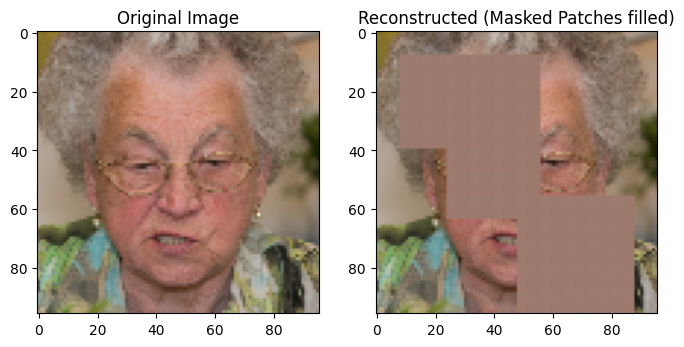

In [23]:
trained_model = train_ijepa()

In [27]:
def retrain_ijepa(model):
    # 1) Dataset + DataLoader
    dataset = AffectNetDataset(
        dataset_path="/kaggle/input/affectnet-training-data",
        labels_filename="labels.csv",
        img_size=96,
        patch_size=8,
        nb_mask=4
    )
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # 2) Model + optimizer + loss
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    loss_fn = nn.MSELoss()

    # 3) Train
    for epoch in range(3):
        model.train()
        epoch_loss = 0.0
        k = 0

        for images, context_indices, masks in dataloader:
            images = images.cuda()
            context_indices = context_indices.cuda()
            masks = masks.cuda()

            ctx_emb, tgt_emb, recon = model(images, context_indices, masks)
            # We'll define a naive MSE: e.g. between ctx_emb and tgt_emb
            # Real I-JEPA would do a patch-level or block-level embedding loss

            # 1) forward pass
            ctx_emb, tgt_emb, recon = model(images, context_indices, masks)
            
            # 2) Convert the original images and the reconstructed images to patch tensors
            #    shape => (B, N, 3, patch_size, patch_size)
            original_patches    = image_to_patches(images,  patch_size=model.patch_size)
            reconstructed_patches = image_to_patches(recon, patch_size=model.patch_size)
            
            # 3) We'll accumulate the pixel reconstruction loss for masked patches
            pixel_recon_loss = 0.0
            pixel_count = 0   # to average the pixel loss if desired
            
            B = images.shape[0]  # batch size
            
            # masks: shape (B, nb_masks-1, max_mask_len)
            for m_i in range(masks.shape[1]):
                block_idxs = masks[:, m_i, :]  # (B, max_mask_len)
                for b in range(B):
                    valid_mask_idxs = block_idxs[b][block_idxs[b] != -1]  # the patch indices for this mask
                    for idx_ in valid_mask_idxs:
                        idx_int = idx_.item()
                        # Compare the predicted patch vs. the ground truth patch
                        # shape => (3, patch_size, patch_size)
                        real_patch = original_patches[b, idx_int]       # => (3, 8, 8) if patch_size=8
                        pred_patch = reconstructed_patches[b, idx_int]  # => (3, 8, 8)
            
                        pixel_recon_loss += loss_fn(pred_patch, real_patch)
                        pixel_count += 1
            
            # Optionally average the pixel reconstruction loss
            if pixel_count > 0:
                pixel_recon_loss = pixel_recon_loss / pixel_count
            
            # 4) The original embedding loss
            embedding_loss = loss_fn(ctx_emb, tgt_emb)
            
            # 5) Combine them with a weighting factor alpha
            alpha = 5.0  # you can tune this
            total_loss = embedding_loss + alpha * pixel_recon_loss
            
            # 6) Backprop
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
            if k % 100 == 0:
                if k >= 1000:
                    break
                print(total_loss.item())
            k += 1
        print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(dataloader):.4f}")

    model.eval()
    images, context_indices, masks = next(iter(dataloader))
    images = images.cuda()
    context_indices = context_indices.cuda()
    masks = masks.cuda()

    with torch.no_grad():
        _, _, reconstructed = model(images, context_indices, masks)
        # reconstructed: (B,3,96,96)

    # 5) Visualize
    # We'll show the first sample in the batch
    orig_img  = images[0].cpu().numpy().transpose(1,2,0)         # => (96,96,3)
    recon_img = reconstructed[0].cpu().numpy().transpose(1,2,0)  # => (96,96,3)

    import matplotlib.pyplot as plt
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
    ax1.imshow(orig_img)
    ax1.set_title("Original Image")
    ax2.imshow(recon_img)
    ax2.set_title("Reconstructed (Masked Patches filled)")
    plt.show()

    return model



0.2834698259830475
0.3969108760356903
0.2768133580684662
0.29665857553482056
0.28776031732559204
0.2749035060405731
0.34745439887046814
0.3794526159763336
0.3124210834503174
0.21623052656650543
Epoch 1, Loss: 0.0432
0.23713429272174835
0.3115983009338379
0.238616943359375
0.3160974979400635
0.23876789212226868
0.4447154104709625
0.325711727142334
0.3206193149089813
0.33082178235054016
0.2806028723716736
Epoch 2, Loss: 0.0458
0.27777156233787537
0.30376163125038147
0.36979711055755615
0.2841549515724182
0.4215523898601532
0.3079259991645813
0.29205000400543213
0.2703247666358948
0.30559828877449036
0.22117042541503906
Epoch 3, Loss: 0.0441


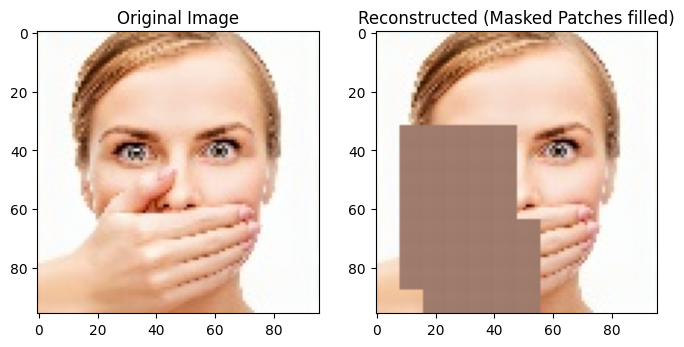

In [29]:
model = retrain_ijepa(trained_model)

# LAST 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

########################################################
# 1) Patch Embedding
########################################################
class PatchEmbed(nn.Module):
    """
    Splits an image into patches (patch_size x patch_size),
    then applies a linear projection => (B, N, embed_dim).
    """
    def __init__(self, img_size=96, patch_size=8, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # A simple convolution that extracts patches:
        self.proj = nn.Conv2d(
            in_channels=3,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        """
        x: (B,3,H,W). Returns: (B, N, embed_dim),
        where N = (H/patch_size)*(W/patch_size).
        """
        x = self.proj(x)               # => (B, embed_dim, H//p, W//p)
        x = x.flatten(2).transpose(1,2)# => (B, N, embed_dim)
        return x


########################################################
# 2) A simple ViT-Encoder that returns (B, N, embed_dim)
########################################################
class ViTEncoder(nn.Module):
    """
    A TransformerEncoder that produces a token per patch 
    (no CLS token).
    """
    def __init__(self, embed_dim=256, depth=4, num_heads=4, max_patches=144):
        super().__init__()
        self.pos_emb = nn.Parameter(torch.zeros(1, max_patches, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4*embed_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

    def forward(self, x):
        # x: (B, N, embed_dim)
        B, N, D = x.shape
        pos = self.pos_emb[:, :N, :]          # (1, N, D)
        x = x + pos                           # add positional embeddings
        x = self.transformer(x)               # => (B, N, D)
        return x


########################################################
# 3) "XEncoder" and "YEncoder" wrappers
########################################################
class XEncoder(nn.Module):
    """
    Encodes the *visible (unmasked)* patches of x into patch-level embeddings.
    """
    def __init__(self, img_size=96, patch_size=8, embed_dim=256):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, embed_dim)
        self.encoder = ViTEncoder(embed_dim=embed_dim)

    def forward(self, x_context):
        # x_context might have zeros for masked patches
        # shape => (B, 3, H, W)
        patches = self.patch_embed(x_context)   # (B, N, embed_dim)
        tokens  = self.encoder(patches)         # (B, N, embed_dim)
        return tokens

class YEncoder(nn.Module):
    """
    Encodes the *full* image y => returns patch embeddings for all patches.
    """
    def __init__(self, img_size=96, patch_size=8, embed_dim=256):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, embed_dim)
        self.encoder = ViTEncoder(embed_dim=embed_dim)

    def forward(self, x_full):
        # x_full => (B,3,H,W)
        patches = self.patch_embed(x_full)  # => (B, N, embed_dim)
        tokens  = self.encoder(patches)     # => (B, N, embed_dim)
        return tokens


########################################################
# 4) The "Predictor" for the I-JEPA approach (figure (c))
########################################################
class PredictorTransformer(nn.Module):
    """
    Merges visible tokens + M mask tokens, attends, 
    then the last M tokens are the predicted embeddings for masked patches.
    """
    def __init__(self, embed_dim=256, depth=2, num_heads=4, max_patches=144):
        super().__init__()
        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_emb    = nn.Parameter(torch.zeros(1, max_patches, embed_dim))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4*embed_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=depth)

    def forward(self, visible_tokens, visible_ids, masked_ids):
        """
        visible_tokens: (B, N_vis, embed_dim)
        visible_ids: (B, N_vis) => patch IDs for visible
        masked_ids:  (B, M) => patch IDs for masked
        Returns: predicted_masked => (B, M, embed_dim)
        """
        B, N_vis, D = visible_tokens.shape
        _, M = masked_ids.shape
        
        # mask tokens => (B, M, D)
        mask_tokens = self.mask_token.expand(B, M, D)

        # Concat => (B, N_vis+M, D)
        cat_tokens = torch.cat([visible_tokens, mask_tokens], dim=1)

        # Add position embeddings:
        # 1) Squeeze out the first dimension of self.pos_emb so it becomes (max_patches, D)
        pos_emb_squeezed = self.pos_emb[0]  # shape (max_patches, D)
        
        # 2) Use advanced indexing
        pos_vis = pos_emb_squeezed[visible_ids]  # (B, N_vis, D)
        pos_msk = pos_emb_squeezed[masked_ids]   # (B, M, D)
        
        # 3) Concatenate
        cat_pos = torch.cat([pos_vis, pos_msk], dim=1)  # (B, N_vis+M, D)

        x_in = cat_tokens + cat_pos
        x_out = self.transformer(x_in)  # => (B, N_vis+M, D)

        # The last M tokens are for the masked patches:
        predicted_masked = x_out[:, N_vis:, :]  # (B, M, D)
        return predicted_masked


########################################################
# 5) A "Generative Decoder" for pixel reconstruction (figure (b))
########################################################
class GenerativeDecoder(nn.Module):
    """
    A toy "decoder" that tries to reconstruct the masked patches 
    in pixel space (like a mini Masked Autoencoder).
    
    We'll do a small Transformer that merges visible tokens + M learned mask tokens
    => produce (B, N, embed_dim), then decode the entire set or just masked patches to pixels.
    """
    def __init__(self, embed_dim=256, depth=2, num_heads=4, 
                 patch_size=8, max_patches=144):
        super().__init__()
        self.patch_size = patch_size
        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_emb    = nn.Parameter(torch.zeros(1, max_patches, embed_dim))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4*embed_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=depth)

        # final projection from embed => patch pixels:
        self.head = nn.Linear(embed_dim, 3*patch_size*patch_size)

    def forward(self, visible_tokens, visible_ids, masked_ids):
        """
        visible_tokens: (B, N_vis, embed_dim)
        visible_ids:    (B, N_vis)
        masked_ids:     (B, M)
        Returns:
          recon_patches: (B, M, 3, patch_size, patch_size) => 
                         the reconstructed masked patches in pixel space
        """
        B, N_vis, D = visible_tokens.shape
        _, M = masked_ids.shape
        # 1) Combine visible tokens + M mask tokens
        mask_tokens = self.mask_token.expand(B, M, D)   # (B, M, D)
        cat_tokens  = torch.cat([visible_tokens, mask_tokens], dim=1)  # (B, N_vis+M, D)

        # 2) Positional embeddings
        pos_vis = self.pos_emb[:, visible_ids, :]        # (B, N_vis, D)
        pos_msk = self.pos_emb[:, masked_ids, :]         # (B, M, D)
        cat_pos  = torch.cat([pos_vis, pos_msk], dim=1)  # (B, N_vis+M, D)
        x_in = cat_tokens + cat_pos

        # 3) Forward the small transformer
        x_out = self.transformer(x_in)  # => (B, N_vis+M, D)

        # 4) slice out the last M tokens => masked patches
        masked_out = x_out[:, N_vis:, :]  # (B, M, D)

        # 5) map each masked patch embedding => pixels
        masked_pixels = self.head(masked_out)   # (B, M, 3*patch^2)
        masked_pixels = masked_pixels.view(B, M, 3, self.patch_size, self.patch_size)
        return masked_pixels


########################################################
# 6) A "UnifiedModel" that can do either:
#    - "predictive" (I-JEPA style) => MSE in embedding space
#    - "generative" => MSE in pixel space
########################################################
class UnifiedModel(nn.Module):
    def __init__(self, 
                 architecture='predictive',  # or 'generative'
                 img_size=96, 
                 patch_size=8, 
                 embed_dim=256):
        super().__init__()
        self.architecture = architecture  # "predictive" or "generative"

        # x-encoder for visible patches
        self.x_encoder = XEncoder(img_size, patch_size, embed_dim)

        if self.architecture == 'predictive':
            # y-encoder for full image => target embeddings
            self.y_encoder  = YEncoder(img_size, patch_size, embed_dim)
            # small predictor
            self.predictor  = PredictorTransformer(embed_dim=embed_dim)

        elif self.architecture == 'generative':
            # a single "decoder" that tries to reconstruct masked patches
            self.decoder = GenerativeDecoder(
                embed_dim=embed_dim, 
                patch_size=patch_size
            )

        else:
            raise ValueError("architecture must be 'predictive' or 'generative'")

    def forward(self, 
                x_context, 
                x_full, 
                visible_ids, 
                masked_ids):
        """
        x_context: (B,3,H,W) => partially masked image (only visible patches kept)
        x_full:    (B,3,H,W) => the full, original image
        visible_ids: (B, N_vis) => indices of the visible patches
        masked_ids:  (B, M)     => indices of the masked patches
        Returns: (loss, optional_reconstruction)
        """
        # 1) x-encoder => visible patch embeddings
        x_vis = self.x_encoder(x_context)  # (B, N_vis, embed_dim)

        if self.architecture == 'predictive':
            # (c) Joint-Embedding Predictive
            # a) predictor => predicted embeddings for masked patches
            pred_m = self.predictor(x_vis, visible_ids, masked_ids)  # (B, M, embed_dim)

            # b) y_encoder => get embeddings for *all* patches, gather masked subset
            y_all = self.y_encoder(x_full)            # (B, N, embed_dim)
            B, M = masked_ids.shape
            batch_idx = torch.arange(B).unsqueeze(-1) # (B,1)
            target_m  = y_all[batch_idx, masked_ids, :]  # (B, M, embed_dim)

            # c) MSE in embedding space
            loss = F.mse_loss(pred_m, target_m)
            return loss, None  # no pixel recon

        else:
            # (b) Generative Architecture
            # a) decode => predicted masked patches in pixel space
            masked_recon = self.decoder(x_vis, visible_ids, masked_ids) 
            # shape => (B, M, 3, patch_size, patch_size)

            # b) gather the real pixels from x_full for those patches => (B, M, 3, p, p)
            B, M = masked_ids.shape
            # We'll build a "target_patches" of shape (B, M, 3, p, p)
            patch_size = masked_recon.shape[-1]
            target_patches = []
            N_w = x_full.shape[3] // patch_size  # e.g. 12 if 96/8

            for b in range(B):
                real_patches_b = []
                for m_idx in masked_ids[b]:
                    # m_idx is the patch index
                    row = m_idx // N_w
                    col = m_idx %  N_w
                    y0 = row * patch_size
                    x0 = col * patch_size
                    # slice from x_full[b, :, y0:y0+p, x0:x0+p]
                    real_patch = x_full[b, :, y0:y0+patch_size, x0:x0+patch_size]
                    real_patches_b.append(real_patch)
                real_patches_b = torch.stack(real_patches_b, dim=0) # (M,3,p,p)
                target_patches.append(real_patches_b)
            target_patches = torch.stack(target_patches, dim=0) # (B, M,3,p,p)

            # c) MSE in pixel space
            loss = F.mse_loss(masked_recon, target_patches)

            return loss, masked_recon  # we can return the reconstruction for visualization




In [5]:
########################################################
# 7) Minimal usage example
########################################################
B = 2
img_size = 96
patch_size = 8
N = (img_size // patch_size)**2  # 96//8=12 => 12*12=144
M = 10                            # number of masked patches

# create random images
x_full = torch.randn(B,3,img_size,img_size)

# define which patches are masked vs visible
masked_ids_list = []
for _ in range(B):
    perm = torch.randperm(N)
    masked_ids_list.append(perm[:M])
masked_ids = torch.stack(masked_ids_list, dim=0)  # (B, M)

visible_ids_list = []
for b in range(B):
    mask_set = set(masked_ids[b].tolist())
    vis_ids  = [i for i in range(N) if i not in mask_set]
    visible_ids_list.append(torch.tensor(vis_ids, dtype=torch.long))
# pad them all to the same length
max_vis = max(len(v) for v in visible_ids_list)
for b in range(B):
    diff = max_vis - len(visible_ids_list[b])
    if diff > 0:
        # just repeat the last index
        last = visible_ids_list[b][-1].item()
        padvals = torch.full((diff,), last, dtype=torch.long)
        visible_ids_list[b] = torch.cat([visible_ids_list[b], padvals], dim=0)
visible_ids = torch.stack(visible_ids_list, dim=0)  # (B, N_vis)
N_vis = visible_ids.shape[1]

# build x_context by zeroing out masked patches
x_context = x_full.clone()
for b in range(B):
    for mid in masked_ids[b]:
        mid = mid.item()
        row = mid // (img_size // patch_size)
        col = mid %  (img_size // patch_size)
        y0 = row * patch_size
        x0 = col * patch_size
        x_context[b,:,y0:y0+patch_size,x0:x0+patch_size] = 0.

print("=== I-JEPA (Predictive) example ===")
predictive_model = UnifiedModel(architecture='predictive', 
                                img_size=img_size, 
                                patch_size=patch_size, 
                                embed_dim=256)
opt = torch.optim.Adam(predictive_model.parameters(), lr=1e-4)
for step in range(3):
    opt.zero_grad()
    loss, _ = predictive_model(x_context, x_full, visible_ids, masked_ids)
    loss.backward()
    opt.step()
    print(f"[Predictive] Step {step+1}, loss={loss.item():.4f}")

print("\n=== Generative (MAE-like) example ===")
generative_model = UnifiedModel(architecture='generative', 
                                img_size=img_size, 
                                patch_size=patch_size, 
                                embed_dim=256)
opt2 = torch.optim.Adam(generative_model.parameters(), lr=1e-4)
for step in range(3):
    opt2.zero_grad()
    loss, masked_recon = generative_model(x_context, x_full, visible_ids, masked_ids)
    loss.backward()
    opt2.step()
    print(f"[Generative] Step {step+1}, pixel-loss={loss.item():.4f}")
print("Done.")


=== I-JEPA (Predictive) example ===


RuntimeError: The size of tensor a (154) must match the size of tensor b (144) at non-singleton dimension 1

In [6]:
import torch

def run_inference_on_single_sample(model, dataset, index=0):
    """
    Runs a forward pass on a single sample from the dataset, prints the shapes of 
    context/target embeddings, and optionally computes an MSE to see if the model 
    is consistent.
    """
    model.eval()
    with torch.no_grad():
        # 1) Grab a single sample
        images, context_indices, masks = dataset[index]  # shapes: 
        #    images: (3, 96, 96)
        #    context_indices: (144,) with -1 padding
        #    masks: (nb_masks-1, max_mask_length) with -1 padding

        # 2) Add batch dimension
        images = images.unsqueeze(0).cuda()             # => (1, 3, 96, 96)
        context_indices = context_indices.unsqueeze(0).cuda()  # => (1, 144)
        masks = masks.unsqueeze(0).cuda()               # => (1, nb_masks-1, max_mask_length)

        # 3) Forward pass
        predictions, targets = model(images, context_indices, masks)
        # predictions, targets are lists of length = nb_masks-1
        # each entry in predictions/targets is (B, embed_dim) => here B=1

        # 4) Print shapes
        print("Number of mask blocks:", len(predictions))
        for i, (pred_i, targ_i) in enumerate(zip(predictions, targets)):
            print(f"Mask block {i}: pred shape {pred_i.shape}, target shape {targ_i.shape}")

        # 5) Optionally compute MSE for each block, just to see if it’s large or small
        mse_fn = torch.nn.MSELoss()
        total_mse = 0.0
        for p, t in zip(predictions, targets):
            total_mse += mse_fn(p, t).item()
        print(f"Total MSE across all blocks: {total_mse:.4f}")


In [10]:
trained_model.eval()
dataset = AffectNetDataset(
        dataset_path="/kaggle/input/affectnet-training-data",
        labels_filename="labels.csv",
        img_size=96,
        patch_size=8,
        nb_mask=4
    )
single_sample_index = 0
run_inference_on_single_sample(trained_model, dataset, index=single_sample_index)


Number of mask blocks: 3
Mask block 0: pred shape torch.Size([1, 768]), target shape torch.Size([1, 768])
Mask block 1: pred shape torch.Size([1, 768]), target shape torch.Size([1, 768])
Mask block 2: pred shape torch.Size([1, 768]), target shape torch.Size([1, 768])
Total MSE across all blocks: 0.0000


In [24]:
torch.save(trained_model.state_dict(), "ijeparun.pth")

In [25]:
model = IJEPAModel()
model.load_state_dict(torch.load("ijeparun.pth"))
model.cuda()
model.eval()


<ipython-input-25-28866ea858fc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ijeparun.pth"))


IJEPAModel(
  (context_encoder): ContextEncoder(
    (context_encoder): VisionTransformer(
      (conv_proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
      (encoder): Encoder(
        (dropout): Dropout(p=0.0, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
            (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features=768, bias=True)
              (4): Dropout(p=0.0, inplace=False)
      

In [1]:
import pandas as pd
import torch
import os
import numpy as np

from torch.utils.data import Dataset
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
from typing import Tuple

def pad_masks(masks, max_length, pad_value=-1):
    """
    Pads each mask to the same length with pad_value.

    Args:
        masks: List of tensors or lists where each element is a mask.
        max_length: The desired length for all masks.
        pad_value: The value to use for padding (default: -1).

    Returns:
        A tensor of shape (len(masks), max_length) with padded masks.
    """
    padded_masks = [
        torch.cat([mask, torch.full((max_length - len(mask),), pad_value)])
        for mask in masks
    ]
    return torch.stack(padded_masks)


class AffectNetDataset(Dataset):
    def __init__(
        self,
        dataset_path: str,
        labels_filename: str,
        img_size: int,
        patch_size: int,
        nb_mask: int = 4,
        aspect_ratio_range_mask: Tuple[int, int] = (0.75, 1.5),
        scale_range_mask: Tuple[int, int] = (0.15, 0.2),
        aspect_ratio_range_context: Tuple[int, int] = (
            1.0,
            1.0,
        ),  # unit aspect ratio for context
        scale_range_context: Tuple[int, int] = (0.85, 1.0),
        max_mask_length: int = 50,  # Add a fixed maximum mask length
    ):
        self.df = pd.read_csv(os.path.join(dataset_path, labels_filename))
        self.dataset_path = dataset_path

        self.img_size = img_size
        self.patch_size = patch_size
        self.sqrt_count_patch = img_size // patch_size
        self.nb_mask = nb_mask

        self.aspect_ratio_range_mask = aspect_ratio_range_mask
        self.scale_range_mask = scale_range_mask

        self.aspect_ratio_range_context = aspect_ratio_range_context
        self.scale_range_context = scale_range_context

        self.max_mask_length = max_mask_length  # Add this attribute

    def __len__(self):
        """
        Returns the length of the dataset, which is the length of df.
        """
        return len(self.df)

    def get_random_width_and_height(self, n: int):
        """
        Returns a random height and weight based on a random aspect ratio and a random scale.\\
        Length of height and width is n+1, the first n elements being masks height and width, and the last one being the context height and weight.

        Parameters:
        - n: the number of height and width to be generated. 
        """
        aspect_ratio = torch.FloatTensor(n).uniform_(*self.aspect_ratio_range_mask)
        scale = torch.FloatTensor(n).uniform_(*self.scale_range_mask)

        aspect_ratio = torch.cat((
            aspect_ratio,
            torch.FloatTensor(1).uniform_(*self.aspect_ratio_range_context),
        ), dim=0)
        
        scale = torch.cat((
            scale,
            torch.FloatTensor(1).uniform_(*self.scale_range_context),
        ), dim=0)

        # calculate area, width and height of each mask and context
        area = scale * (self.sqrt_count_patch**2)
        height = torch.sqrt(area / aspect_ratio).round().int()
        width = torch.sqrt(area * aspect_ratio).round().int()

        return height, width

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, self.df.iloc[idx]["pth"])
        img = Image.open(img_path).convert("RGB")
        img = pil_to_tensor(img).float() / 255.0

        heights, widths = self.get_random_width_and_height(self.nb_mask)
        
        xs = torch.tensor([
            torch.randint(
                low=0,
                high=int(self.sqrt_count_patch - width + 1),
                size=(1,)
            ).item() for width in widths[:-1]
        ])
        
        ys = torch.tensor([
            torch.randint(
                low=0,
                high=int(self.sqrt_count_patch - height + 1),
                size=(1,)
            ).item() for height in heights[:-1]
        ])
    
        masks = []
        masks_indexes = set()
        z = zip(xs, ys, heights[:-1], widths[:-1])
        for x, y, height, width in z:
            tmp_mask = torch.cat(
                [
                    torch.arange(x, x + width) + (y + i) * self.sqrt_count_patch
                    for i in range(height)
                ]
            )
            masks_indexes.update(tmp_mask.tolist())
            masks.append(tmp_mask)
    
        context_indexes = set(
            torch.cat(
                [
                    torch.arange(xs[-1], xs[-1] + widths[-1])
                    + (ys[-1] + i) * self.sqrt_count_patch
                    for i in range(heights[-1])
                ]
            ).tolist()
        )

        # Use a fixed maximum length for masks
        padded_masks = pad_masks(masks, self.max_mask_length)

        max_context_length = self.sqrt_count_patch**2  # Use maximum possible patches as fixed length
        padded_context_indexes = list(context_indexes) + [-1] * (max_context_length - len(context_indexes))
        padded_context_indexes = torch.tensor(padded_context_indexes, dtype=torch.long)
        
        padded_masks = pad_masks(masks, self.max_mask_length)
    

        return img, padded_context_indexes, padded_masks





In [2]:
dataset = AffectNetDataset(
    dataset_path="/kaggle/input/affectnet-training-data",
    labels_filename="labels.csv",
    img_size=96,
    patch_size=8
)





In [3]:
import torch
import torch.nn as nn

def image_to_patches(images: torch.Tensor, patch_size: int) -> torch.Tensor:
    """
    Splits a batch of images into non-overlapping patches.

    Args:
        images: A batch of images of shape (B, C, H, W).
        patch_size: The patch width and height.

    Returns:
        patches: A tensor of shape (B, N, C, patch_size, patch_size),
                 where N = (H / patch_size) * (W / patch_size).
    """
    B, C, H, W = images.shape

    unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    # unfold_out: (B, C*patch_size*patch_size, N)
    unfold_out = unfold(images)

    # Transpose to get (B, N, C*patch_size*patch_size)
    unfold_out = unfold_out.transpose(1, 2)
    # Reshape to (B, N, C, patch_size, patch_size)
    patches = unfold_out.view(
        B, -1, C, patch_size, patch_size
    )
    return patches


In [4]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torchvision.models import VisionTransformer
import numpy as np

print(torch.cuda.is_available())  # Should print True
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.current_device())  # Index of the current GPU
print(torch.cuda.get_device_name(0))  # Name of the first GPU



# Define the context encoder
class ContextEncoder(nn.Module):
    def __init__(self, embed_dim):
        super(ContextEncoder, self).__init__()
        # Custom Vision Transformer
        self.context_encoder = VisionTransformer(
            image_size=96,
            patch_size=8,
            num_layers=12,
            num_heads=12,
            hidden_dim=embed_dim,
            mlp_dim=4 * embed_dim,
            num_classes=0,
        )
        self.context_encoder.heads = nn.Identity()

    def forward(self, x):
        return self.encoder(x)


# Define the target encoder
class TargetEncoder(nn.Module):
    def __init__(self, embed_dim):
        super(TargetEncoder, self).__init__()
        # Custom Vision Transformer
        self.encoder = VisionTransformer(
            image_size=96,
            patch_size=8,
            num_layers=12,
            num_heads=12,
            hidden_dim=embed_dim,
            mlp_dim=4 * embed_dim,
            num_classes=0,
        )
        self.encoder.heads = nn.Identity()  # Remove classification head

    def forward(self, x):
        return self.encoder(x)

# Define the predictor
class Predictor(nn.Module):
    def __init__(self, embed_dim):
        super(Predictor, self).__init__()
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim),
        )

    def forward(self, context_representations, mask_tokens):
        return self.predictor(context_representations + mask_tokens)

# Full I-JEPA model
class IJEPAModel(nn.Module):
    def __init__(self, embed_dim, nb_masks=4, patch_size=8):
        super().__init__()
        self.context_encoder = ContextEncoder(embed_dim)
        self.target_encoder = TargetEncoder(embed_dim)
        self.predictor = Predictor(embed_dim)
        self.mask_token = nn.Parameter(torch.randn(1, embed_dim))
        self.nb_masks = nb_masks
        self.patch_size = patch_size
        
    def forward(self, images, context_indices, masks):
        """
        images: (B, 3, 96, 96)
        context_indices: (B, max_context_length) with possibly some -1 paddings
        masks: list of length B (?), each element is a set of patch indices...
               or shape (B, nb_mask, max_mask_length) with -1 padding
        """
        B, C, H, W = images.shape

        # 1) Convert to (B, N, C, patch_size, patch_size)
        patches = image_to_patches(images, patch_size=self.patch_size)
        # patches.shape = (B, N, C, 8, 8)
        N = patches.shape[1]

        # 2) Build the "masked image" for the context
        #    or, if you prefer, build a smaller bounding box image. We'll do full masked version for simplicity:
        masked_images = torch.zeros_like(images)  # (B, 3, 96, 96)

        # Convert context_indices from shape (B, max_len) => per item
        # filter out -1. Then for each valid index, copy the patch into the masked_images
        for b in range(B):
            valid_context = context_indices[b][context_indices[b] != -1]  # shape (num_ctx_patches,)
            for idx_ in valid_context:
                idx_ = idx_.item()  # an integer in [0..N-1]
                # Compute top-left coordinate of patch
                row = idx_ // (W // self.patch_size)
                col = idx_ %  (W // self.patch_size)
                y0, x0 = row * self.patch_size, col * self.patch_size
                # Copy from patches[b, idx_] => shape (C, 8, 8)
                masked_images[b, :, y0:y0+self.patch_size, x0:x0+self.patch_size] = patches[b, idx_]

        # 3) Pass masked_images (B, 3, 96, 96) through context encoder
        context_representation = self.context_encoder(masked_images)  
        # shape will be (B, embed_dim), or (B, num_patches, embed_dim), depending on your ViT design

        # 4) For each mask block: 
        #    a) gather the target patches 
        #    b) pass them to the target encoder (optionally we do the *full* image in the target encoder)
        #    c) predict and compute the MSE
        predictions = []
        target_reps = []
        # Suppose `masks` is shape (B, nb_masks, max_mask_len)
        for m_i in range(self.nb_masks):
            # Gather target patches
            # We'll build a "target image" for each mask block if you want. Or do the full image. 
            # For simpler code, let's do the full image => that means the target encoder sees everything:
            # Then we only index out the final representation from target encoder for the masked patches.
            target_full_repr = self.target_encoder(images)  # (B, embed_dim) or (B, 197, embed_dim) etc.

            # We'll pretend target_full_repr is patch-level => (B, N, embed_dim).
            # if it’s not, adapt accordingly.
            # gather only the patches that belong to this mask block
            mask_indices = masks[:, m_i, :]  # shape (B, max_mask_len)
            # filter out -1
            # (in a real code, you'd have to also handle if your ViT returns a CLS token in position 0, etc.)
            # then average or keep them as a set
            # For demonstration, let's say we average them
            # If your target encoder doesn't output patch-level embeddings, you'll need a different approach.

            # Meanwhile the predictor needs context_representation plus a mask token for each patch we want to predict:
            # Example predictor usage:
            #   prediction = self.predictor(context_representation, mask_tokens_for_these_patches)
            # ...

            # Store them
            predictions.append(None)
            target_reps.append(None)

        return predictions, target_reps





True
1
0
Tesla P100-PCIE-16GB


In [5]:
# Training loop
def train_ijepa():
    # Dataset and DataLoader
    dataset = AffectNetDataset(
        dataset_path="/kaggle/input/affectnet-training-data",
        labels_filename="labels.csv",
        img_size=96,
        patch_size=8
    )
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Model, optimizer, and loss
    model = IJEPAModel(embed_dim=768, nb_masks=4).cuda()
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    loss_fn = nn.MSELoss()

    for epoch in range(10):  # Specify number of epochs
        model.train()
        epoch_loss = 0
        for images, context_indices, masks in dataloader:
            images = images.cuda()
            context_indices = context_indices.cuda()
            masks = masks.cuda()
        
            # Forward pass
            predictions, targets = model(images, context_indices, masks)

            # Compute loss
            loss = sum(loss_fn(pred, target) for pred, target in zip(predictions, targets))
            epoch_loss += loss.item()

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader)}")

if __name__ == "__main__":
    train_ijepa()

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


IndexError: index 144 is out of bounds for dimension 1 with size 144